In [263]:
from src_ci_hi_nh.data.eeg_measurement import EegMeasurement
from src_ci_hi_nh.data.eeg_attention_pytorch_dataset import EegAttentionDataset
from src_ci_hi_nh.evaluation.ridge_evaluator import RidgeEvaluator

import numpy as np
import git
import os
import pandas
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import scipy
import seaborn as sns

import git
import src_ci_hi_nh.data.utils as data_utils
import src_ci_hi_nh.evaluation.utils as eval_utils
import pickle

import matplotlib.ticker as mtick
from matplotlib.lines import Line2D

from scipy.stats import f_oneway as anova
from scipy.stats import ttest_ind as ttest
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.multicomp import pairwise_tukeyhsd

from os.path import join
from pandas import read_csv
import json
import pingouin as pg
#wilcoxon
from scipy.stats import wilcoxon
import statsmodels.formula.api as smf

In [264]:
ridge_model_config = 'model_2.json'
ridge_model_config_ci = 'model_3.json'
cnn_model_config = 'model_503.json'

In [265]:
base_dir = git.Repo('.', search_parent_directories=True).working_tree_dir
fig_path = os.path.join(base_dir, 'reports', 'figures', 'decoding')

plt.rcParams["font.family"] = "Times New Roman"
c_cnn = '#1f77b4'
c_ridge = '#ff7f0e'

c_ci = 'slategrey'
c_hi = 'darkorange'
c_nh = 'seagreen'

ridge_config_path = os.path.join(base_dir, 'models', 'configs', 'ridge' , ridge_model_config)
with open(ridge_config_path, 'r') as f:
    ridge_config = json.load(f)

cnn_config_path = os.path.join(base_dir, 'models', 'configs', 'cnn' , cnn_model_config)
with open(cnn_config_path, 'r') as f:
    cnn_config = json.load(f)
fig_path = os.path.join(base_dir, 'reports', 'figures', 'decoding')

# subejct identifiers for different cohorts
subjects_dict = {'ci': list(range(102, 115)) + list(range(116, 117)) + list(range(118, 126)) + [127, 128, 130],
                'hi': list(range(201,230)),
                'nh': list(range(301,329))
}

acc_window_sizes = np.array([60,45,30,20,10,5,2,1])

ridge_model_id = f"{ridge_config['model_id']:03}"
ridge_model_id_ci = f"{ridge_config['model_id']:03}"

cnn_model_id = f"{cnn_config['model_id']:03}"

In [266]:
subjects = list(range(102, 115)) + list(range(116, 117)) + list(range(118, 126)) + [127, 128, 130]


## Load Reconstruction Scores and accurcy

In [267]:
rec_scores = eval_utils.load_rec_scores(base_dir, ridge_model_id, 'ridge')
#Use model results from CI cohort, that were ICA cleaned
rec_scores_ci = eval_utils.load_rec_scores(base_dir, ridge_model_id_ci, 'ridge', 'ci')
rec_scores['ci'] = rec_scores_ci['ci']

accuracies = eval_utils.load_accuracies(base_dir, ridge_model_id, 'ridge')
#Use model results from CI cohort, that were ICA cleaned
accuracies_ci = eval_utils.load_accuracies(base_dir, ridge_model_id_ci, 'ridge', 'ci')
accuracies['ci'] = accuracies_ci['ci']

In [268]:
cohort_data_ci = data_utils.get_cohort_data(base_dir, 'ci')
cohort_data_hi = data_utils.get_cohort_data(base_dir, 'hi')
cohort_data_nh = data_utils.get_cohort_data(base_dir, 'nh')

In [269]:
behav_data_ci = data_utils.get_behavioural_data(base_dir, subjects_dict['ci'])
behav_data_hi = data_utils.get_behavioural_data(base_dir, subjects_dict['hi'])
behav_data_nh = data_utils.get_behavioural_data(base_dir, subjects_dict['nh'])

102
103
104
105
106
107
108
109
110
111
112
113
114
116
118
119
120
121
122
123
124
125
127
128
130
102
103
104
105
106
107
108
109
110
111
112
113
114
116
118
119
120
121
122
123
124
125
127
128
130
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328


## Analyze interaction between listening effort comprehension and reconstruction scores accuracy

### NH data

In [270]:
rec_scores_nh_att = rec_scores['nh']['attended']
rec_scores_nh_distr = rec_scores['nh']['distractor']
list_eff_comp = (behav_data_nh['lis_eff_comp_pol'] + behav_data_nh['lis_eff_comp_elb']) / 2

PearsonRResult(statistic=0.03801084916309558, pvalue=0.847716018355763)


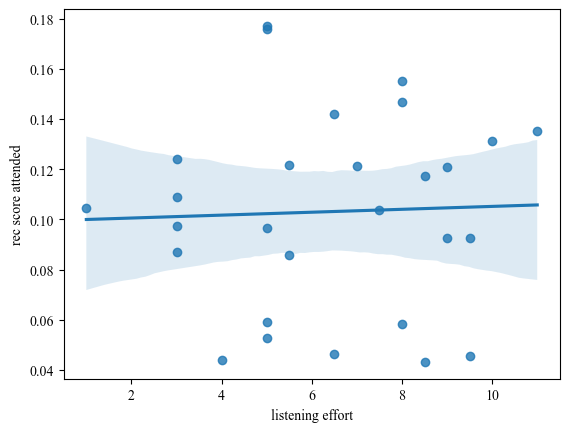

In [271]:
part_rec = rec_scores_nh_att[:,:,-1].mean(axis=(1))
sns.regplot(x='listening effort', y='rec score attended', data=pandas.DataFrame({'listening effort': list_eff_comp, 'rec score attended': part_rec}))
corr_result = scipy.stats.pearsonr(list_eff_comp, part_rec)
print(corr_result)

In [272]:
accuracies_nh = accuracies['nh']['accuracies']

In [273]:
accuracies_nh = accuracies_nh[:,:,4].mean(axis=1)

PearsonRResult(statistic=-0.09720374707479615, pvalue=0.6226688947514981)


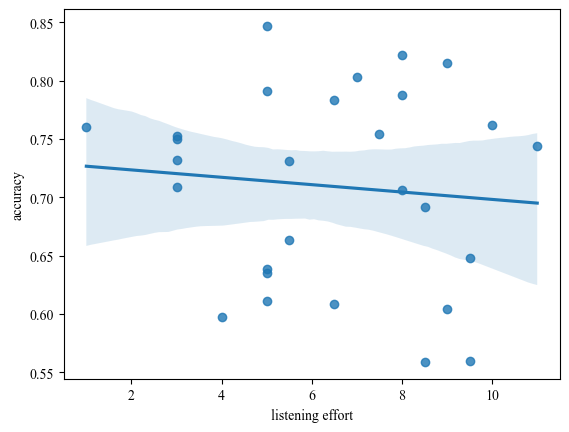

In [274]:
sns.regplot(x='listening effort', y='accuracy', data=pandas.DataFrame({'listening effort': list_eff_comp, 'accuracy': accuracies_nh}))
corr_result = scipy.stats.pearsonr(list_eff_comp, accuracies_nh)
print(corr_result)

### Look into interaction between comprehension and accuracy on trial level

In [275]:
accuracies_ci_cnn = eval_utils.load_accuracies(base_dir, cnn_model_id, 'cnn', 'ci')
accuracies_ci_cnn = accuracies_ci_cnn['ci']['accuracies']

In [276]:
# On CI
accuracies_ci = accuracies_ci['ci']['accuracies']

In [277]:
acc_100 = np.array([])
acc_50 = np.array([])
acc_0 = np.array([])
for subject in subjects_dict['ci']:
    # example path: data/processed/102/102_trials.csv
    path = os.path.join(base_dir, 'data', 'processed', str(subject), f'{subject}_trials.csv')
    data = read_csv(path)

    #get score per trial
    per_trial_scores = np.array(data['answer_1_score'] + data['answer_2_score']) / 2

    subj_index = subjects_dict['ci'].index(subject)
    acc_subj = accuracies_ci[subj_index,:,2]

    competing_scores = per_trial_scores[8:]
    acc_100_subject = acc_subj[competing_scores == 1].flatten()
    acc_50_subject = acc_subj[competing_scores == 0.5].flatten()
    acc_0_subject = acc_subj[competing_scores == 0].flatten()
    #append if not nan
    acc_100 = np.append(acc_100, acc_100_subject)
    acc_50 = np.append(acc_50, acc_50_subject)
    acc_0 = np.append(acc_0, acc_0_subject)

In [278]:
acc_100_cnn = np.array([])
acc_50_cnn = np.array([])
acc_0_cnn = np.array([])
for subject in subjects_dict['ci']:
    # example path: data/processed/102/102_trials.csv
    path = os.path.join(base_dir, 'data', 'processed', str(subject), f'{subject}_trials.csv')
    data = read_csv(path)

    #get score per trial
    per_trial_scores = np.array(data['answer_1_score'] + data['answer_2_score']) / 2

    subj_index = subjects_dict['ci'].index(subject)
    acc_subj = accuracies_ci_cnn[subj_index,:,2]

    competing_scores = per_trial_scores[8:]
    acc_100_subject = acc_subj[competing_scores == 1].flatten()
    acc_50_subject = acc_subj[competing_scores == 0.5].flatten()
    acc_0_subject = acc_subj[competing_scores == 0].flatten()
    #append if not nan
    acc_100_cnn = np.append(acc_100_cnn, acc_100_subject)
    acc_50_cnn = np.append(acc_50_cnn, acc_50_subject)
    acc_0_cnn = np.append(acc_0_cnn, acc_0_subject)

In [279]:
print(pg.normality(acc_100))
print(pg.normality(acc_50))
print(pg.normality(acc_0))

          W          pval  normal
0  0.839903  1.306793e-13   False
          W      pval  normal
0  0.901487  0.000018   False
          W      pval  normal
0  0.873569  0.011123   False


In [280]:
subjects_for_df = np.array([list(np.repeat(s,12)) for s in subjects]).flatten()
trials_for_df = np.array([list(range(9,21)) for s in subjects]).flatten()

In [281]:
trials_for_df

array([ 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,  9, 10, 11, 12, 13,
       14, 15, 16, 17, 18, 19, 20,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,  9, 10, 11,
       12, 13, 14, 15, 16, 17, 18, 19, 20,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,  9,
       10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,  9, 10, 11, 12, 13, 14,
       15, 16, 17, 18, 19, 20,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,  9, 10, 11, 12,
       13, 14, 15, 16, 17, 18, 19, 20,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,  9, 10,
       11, 12, 13, 14, 15, 16, 17, 18, 19, 20,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
        9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,  9, 10, 11, 12, 13,
       14, 15, 16, 17, 18

In [282]:
acc_dict = {'decoding': np.concatenate([acc_0, acc_50, acc_100]),
            'comprehension': np.concatenate([
                np.repeat('0', len(acc_0)),
                np.repeat('50', len(acc_50)),
                np.repeat('100', len(acc_100))
                ]
                ),
            'subject': subjects_for_df,
            'trials': trials_for_df
}
df_acc = pandas.DataFrame(acc_dict)

In [283]:
acc_dict_cnn = {'decoding': np.concatenate([acc_0_cnn, acc_50_cnn, acc_100_cnn]),
            'comprehension': np.concatenate([
                np.repeat('0', len(acc_0_cnn)), 
                np.repeat('50', len(acc_50_cnn)),
                np.repeat('100', len(acc_100_cnn))]
                ),
            'subject': subjects_for_df,
            'trials': trials_for_df
}
df_acc_cnn = pandas.DataFrame(acc_dict_cnn)

In [284]:
25 * 12

300

In [285]:
kruskal = pg.kruskal(df_acc, dv='decoding', between='comprehension')
kruskal

,Source,ddof1,H,p-unc
Kruskal,comprehension,2,14.518454,0.000704


In [286]:
kruskal_cnn = pg.kruskal(df_acc_cnn, dv='decoding', between='comprehension')
kruskal_cnn

,Source,ddof1,H,p-unc
Kruskal,comprehension,2,3.718716,0.155773


In [287]:
anova_cnn = pg.anova(data=df_acc_cnn, dv='decoding', between='comprehension')
anova_cnn

,Source,ddof1,ddof2,F,p-unc,np2
0,comprehension,2,297,2.510765,0.082929,0.016626


In [288]:
stats_100_50_cnn = pg.mwu(acc_100_cnn, acc_50_cnn)
stats_100_0_cnn = pg.mwu(acc_100_cnn, acc_0_cnn)
stats_50_0_cnn = pg.mwu(acc_50_cnn, acc_0_cnn)
#print results
print(stats_100_50_cnn)
print(stats_100_0_cnn)
print(stats_50_0_cnn)

      U-val alternative     p-val       RBC      CLES
MWU  8841.0   two-sided  0.091025  0.127822  0.563911
      U-val alternative     p-val       RBC      CLES
MWU  2435.5   two-sided  0.235478  0.153992  0.576996
     U-val alternative     p-val      RBC     CLES
MWU  848.5   two-sided  0.801121  0.03602  0.51801


In [289]:
tt_100_50_cnn = pg.ttest(acc_100_cnn, acc_50_cnn, paired=False)
tt_100_0_cnn = pg.ttest(acc_100_cnn, acc_0_cnn, paired=False)
tt_50_0_cnn = pg.ttest(acc_50_cnn, acc_0_cnn, paired=False)
#print results
print(tt_100_50_cnn)
print(tt_100_0_cnn)
print(tt_50_0_cnn)

               T         dof alternative     p-val          CI95%   cohen-d  \
T-test  1.841569  125.955997   two-sided  0.067891  [-0.01, 0.16]  0.259787   

         BF10     power  
T-test  0.716  0.492352  
               T        dof alternative     p-val          CI95%   cohen-d  \
T-test  1.246943  22.742821   two-sided  0.225108  [-0.07, 0.26]  0.343205   

         BF10     power  
T-test  0.464  0.319469  
               T        dof alternative     p-val         CI95%   cohen-d  \
T-test  0.271341  29.452072   two-sided  0.788021  [-0.15, 0.2]  0.070626   

        BF10     power  
T-test  0.26  0.059319  


In [290]:
multipletests([kruskal['p-unc'].values[0], kruskal_cnn['p-unc'].values[0]], method='fdr_bh')

(array([ True, False]),
 array([0.0014073 , 0.15577258]),
 0.025320565519103666,
 0.025)

In [291]:
pg.mwu(acc_100_cnn, acc_50_cnn)

,U-val,alternative,p-val,RBC,CLES
MWU,8841.0,two-sided,0.091025,0.127822,0.563911


In [292]:
#unpaired t-test
scipy.stats.ttest_ind(acc_100_cnn, acc_0_cnn)

TtestResult(statistic=1.496527212821377, pvalue=0.13594954208217552, df=220.0)

In [293]:
def median_statistic(*args):
    return np.max([np.mean(group) for group in args]) - np.min([np.mean(group) for group in args])

In [294]:
result = scipy.stats.permutation_test((acc_100_cnn, acc_50_cnn),
                          median_statistic,
                          n_resamples=10000,
                          permutation_type = 'independent', 
                          alternative='two-sided')

In [295]:
result

PermutationTestResult(statistic=0.07623421354764659, pvalue=0.0993900609939006, null_distribution=array([0.00177   , 0.04269996, 0.04657482, ..., 0.00742442, 0.05132032,
       0.02816686]))

In [296]:
def group_statistics(df_acc, acc_100, acc_50, acc_0):
    # ANOVA for group difference
    kruskal = pg.kruskal(df_acc, dv='decoding', between='comprehension')
    p_val = kruskal['p-unc'].item()
    h_stat = kruskal['H'].item()
    print(f'Kruskal-Wallis H-test: H = {h_stat}, p = {p_val}')
    # T-test for pairwise comparisons
    if p_val < 0.05:
        stat_100_50 = pg.mwu(acc_100, acc_50)
        p_100_50, U_100_50 = stat_100_50['p-val'].item(), stat_100_50['U-val'].item()

        stat_100_0 = pg.mwu(acc_100, acc_0)
        p_100_0, U_100_0 = stat_100_0['p-val'].item(), stat_100_0['U-val'].item()

        stat_50_0 = pg.mwu(acc_50, acc_0)
        p_50_0, U_50_0 = stat_50_0['p-val'].item(), stat_50_0['U-val'].item()
        # fdr_bhr correction
        p_values = [p_100_50, p_100_0, p_50_0]
        reject, p_values_corrected, _, _ = multipletests(p_values, method='fdr_bh')
        
        print(f'100% vs 50%: U = {U_100_50}, p = {p_values_corrected[0]}')
        print(f'100% vs 0%: t = {U_100_0}, p = {p_values_corrected[1]}')
        print(f'50% vs 0%: t = {U_50_0}, p = {p_values_corrected[2]}\n\n')

        significant_comibinations = [((1,2),  p_values_corrected[0]), ((0,1), p_values_corrected[2]), ((0,2),  p_values_corrected[1])]
    else:
        print('No significant difference between groups')
        significant_comibinations = [((0,1,2), 'n.s.')]
    return significant_comibinations

In [297]:
def sig_decoding(acc, long_res=False):
    n_corr = np.sum(acc > 0.5)
    n_total = len(acc)
    res = scipy.stats.binomtest(n_corr, n_total, p=0.5, alternative='two-sided')
    if long_res:
        return res
    else:
        return res.pvalue

In [298]:
significant_combinations= group_statistics(df_acc, acc_100, acc_50, acc_0)

Kruskal-Wallis H-test: H = 14.518453768409026, p = 0.0007036518297155654
100% vs 50%: U = 9922.5, p = 0.0012259716873753244
100% vs 0%: t = 2654.0, p = 0.0677946428382232
50% vs 0%: t = 834.0, p = 0.9000115330216034




In [299]:
significant_combinations_cnn = group_statistics(df_acc_cnn, acc_100_cnn, acc_50_cnn, acc_0_cnn)

Kruskal-Wallis H-test: H = 3.718716247621706, p = 0.15577258499854924
No significant difference between groups


In [300]:
pg.mwu(acc_50, acc_0)

,U-val,alternative,p-val,RBC,CLES
MWU,834.0,two-sided,0.900012,0.018315,0.509158


In [301]:
sig_decoding(acc_0_cnn, long_res=True)

BinomTestResult(k=12, n=21, alternative='two-sided', statistic=0.5714285714285714, pvalue=0.6636238098144531)

In [302]:
scipy.stats.binomtest(10, 17, alternative='two-sided')

BinomTestResult(k=10, n=17, alternative='two-sided', statistic=0.5882352941176471, pvalue=0.629058837890625)

In [303]:
np.median(acc_0_cnn)

0.6666666666666666

In [304]:
sig_decoding_100 = sig_decoding(acc_100)
sig_decoding_50 = sig_decoding(acc_50)
sig_decoding_0 = sig_decoding(acc_0)
sig_decodings = [sig_decoding_0, sig_decoding_50, sig_decoding_100]
sig_decoding_symbols = ['***' if sig < 0.001 else '**' if sig < 0.01 else '*' if sig < 0.05 else 'n.s.' for sig in sig_decodings]

print(f'Significance of decoding 100%: {sig_decoding_100}')
print(f'Significance of decoding 50%: {sig_decoding_50}')
print(f'Significance of decoding 0%: {sig_decoding_0}')

Significance of decoding 100%: 1.2851891163877225e-06
Significance of decoding 50%: 0.3081682319436807
Significance of decoding 0%: 1.0


In [305]:
sig_decoding_100_cnn = sig_decoding(acc_100_cnn)
sig_decoding_50_cnn = sig_decoding(acc_50_cnn)
sig_decoding_0_cnn = sig_decoding(acc_0_cnn)
sig_decodings_cnn = [sig_decoding_0_cnn, sig_decoding_50_cnn, sig_decoding_100_cnn]
sig_decoding_symbols_cnn = ['***' if sig < 0.001 else '**' if sig < 0.01 else '*' if sig < 0.05 else 'n.s.' for sig in sig_decodings_cnn]

print(f'Significance of decoding 100%: {sig_decoding_100_cnn}')
print(f'Significance of decoding 50%: {sig_decoding_50_cnn}')
print(f'Significance of decoding 0%: {sig_decoding_0_cnn}')

Significance of decoding 100%: 1.0477413530388255e-10
Significance of decoding 50%: 0.030786495821399938
Significance of decoding 0%: 0.6636238098144531


In [306]:
sig_decoding_symbols

['n.s.', 'n.s.', '***']

In [307]:
acc_means = np.array([acc_100.mean(), acc_50.mean(), acc_0.mean()])
acc_stds = np.array([acc_100.std(), acc_50.std(), acc_0.std()])
acc_counts = np.array([len(acc_100), len(acc_50), len(acc_0)])

labels = ['100%', '50%', '0%']

c_ci = 'slategrey'
c_hi = 'darkorange'
c_nh = 'seagreen'

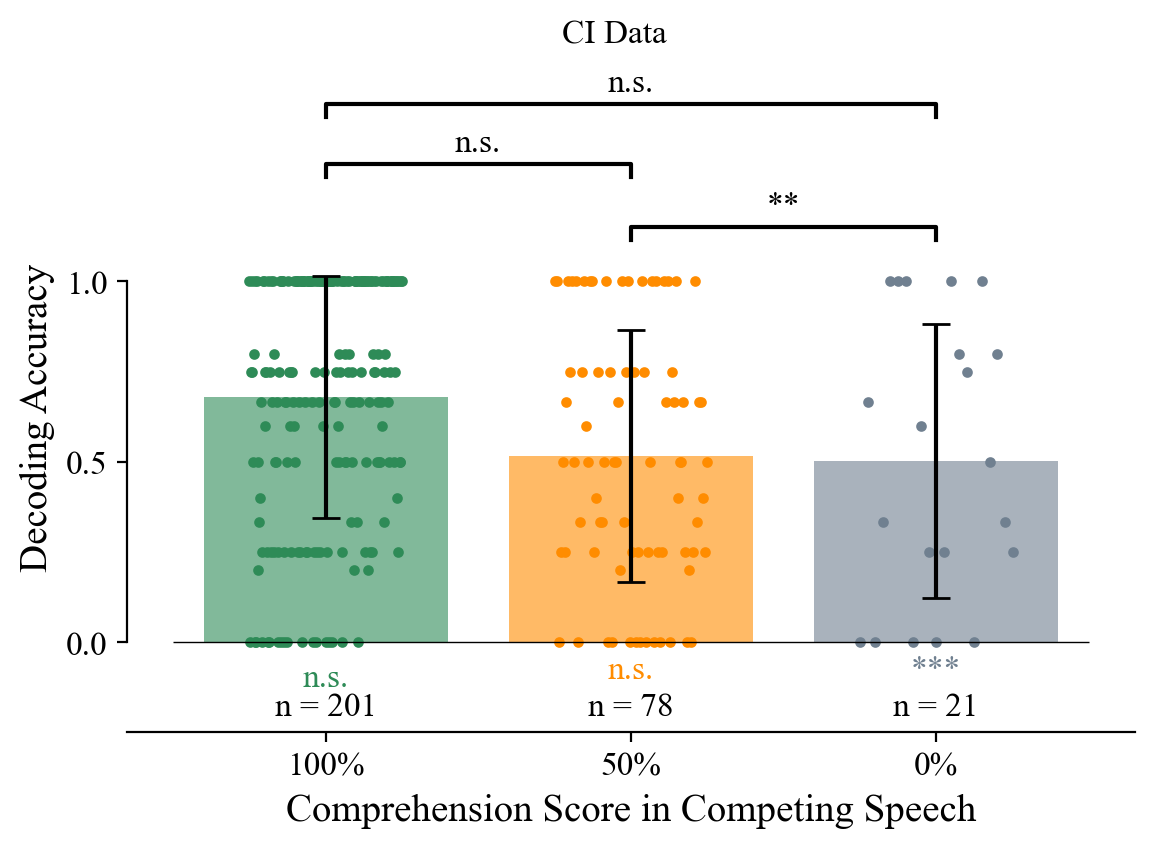

In [308]:
fig = plt.figure(figsize=(6.5, 4.1), dpi=200)
ax = fig.add_subplot(111)
ax.bar(labels, acc_means, yerr=acc_stds, capsize=5, color=[c_nh, c_hi, c_ci], alpha=0.6)
ax.set_ylabel('Decoding Accuracy', fontsize=14)
ax.set_xlabel('Comprehension Score in Competing Speech', fontsize=14)

ax.scatter(np.linspace(-0.25, 0.25, acc_counts[0]), acc_100, color=c_nh, alpha=1, s = 8)
ax.scatter(np.linspace(0.75, 1.25, acc_counts[1]), acc_50, color=c_hi, alpha=1, s = 8)
ax.scatter(np.linspace(1.75, 2.25, acc_counts[2]), acc_0, color=c_ci, alpha=1, s = 8)
ax.set_ylim([-0.25, 1.5])
ax.hlines(0, -0.5, 2.5, color='black', linewidth=0.5)

ax.text(0, -0.22, f"n = {acc_counts[0]}", ha='center', va='bottom', color='black', fontsize=12)
ax.text(0, -0.14, sig_decoding_symbols[0], ha='center', va='bottom', color = c_nh, fontsize=12)

ax.text(1, -0.22, f"n = {acc_counts[1]}", ha='center', va='bottom', color='black', fontsize=12)
ax.text(1, -0.12, sig_decoding_symbols[1], ha='center', va='bottom', color = c_hi, fontsize=12)

ax.text(2, -0.22, f"n = {acc_counts[2]}", ha='center', va='bottom', color='black', fontsize=12)
ax.text(2, -0.12, sig_decoding_symbols[2], ha='center', va='bottom', color = c_ci, fontsize=12)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Significance bars

bottom, top = ax.get_ylim()
y_range = top - bottom
levels = [-4,-2,-0.1]

for i, significant_combination in enumerate(significant_combinations):
    # Columns corresponding to the datasets of interest
    x1 = significant_combination[0][0]
    x2 = significant_combination[0][1]
    # What level is this bar among the bars above the plot?
    level = levels[i]
    
    # Plot the bar
    bar_height = (y_range * 0.05 * level) + top
    bar_tips = bar_height - (y_range * 0.02)
    ax.plot(
        [x1, x1, x2, x2],
        [bar_tips, bar_height, bar_height, bar_tips], lw=1.5, c='k'
    )
    # Significance level
    p = significant_combination[1]
    if p < 0.001:
        sig_symbol = '***'
    elif p < 0.01:
        sig_symbol = '**'
    elif p < 0.05:
        sig_symbol = '*'
    else:
        sig_symbol = 'n.s.'
    text_height = bar_height + (y_range * 0.01)
    ax.text((x1 + x2) * 0.5, text_height, sig_symbol, ha='center', va='bottom', c='k', fontsize=12)

ax.set_yticks([0, 0.5, 1])
ax.spines['left'].set_bounds(0, 1)

#set fontsize of axis ticks
ax.tick_params(axis='both', which='major', labelsize=12)

fig.suptitle('CI Data')

#save figure
fig_path = os.path.join(base_dir, 'reports', 'figures', 'decoding')
fig_name = 'decoding_accuracy_comprehension_score_ci'
#save as pdf
fig.savefig(os.path.join(fig_path, fig_name + '.pdf'), bbox_inches='tight', dpi = 600)

WARNING    /var/folders/ll/btjq1lpn2msbmbn34rst5wz80000gp/T/ipykernel_76848/3340572302.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='comprehension', y='decoding', data=df_acc, palette=[c_nh, c_hi, c_ci])
 [py.warnings]


WARNING    /Users/constantin/opt/anaconda3/envs/ci_hi_nh_study/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 37.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
 [py.warnings]


<Axes: xlabel='comprehension', ylabel='decoding'>

WARNING    /Users/constantin/opt/anaconda3/envs/ci_hi_nh_study/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 32.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
 [py.warnings]


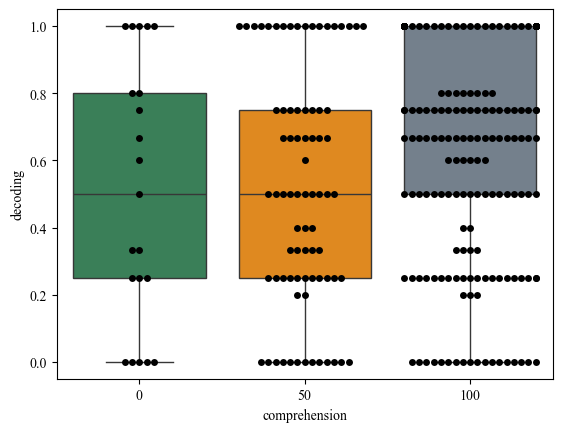

In [309]:
sns.boxplot(x='comprehension', y='decoding', data=df_acc, palette=[c_nh, c_hi, c_ci])
sns.swarmplot(x='comprehension', y='decoding', data=df_acc, color='black')

In [310]:
y_sig = -0.2
y_n = -0.38

In [311]:
def plot_ridge(ax):
    sns.boxplot(x='comprehension', y='decoding', data=df_acc, palette=[c_ci, c_hi, c_nh], ax=ax, width=0.6, saturation=0.75, boxprops=dict(alpha=1), linewidth=1.5)
    ax.set_ylabel('Ridge\ndecoding accuracy', fontsize=12)
    #ax.set_xlabel('Comprehension Score in Competing Speech', fontsize=12)
    


    sns.stripplot(x='comprehension', y='decoding', data=df_acc, color='k', ax=ax, size=4, alpha=0.5)
    ax.set_ylim([-0.4, 1.5])
    #ax.hlines(0, -0.5, 2.5, color='black', linewidth=0.5)
    ax.set_xlabel('') 
    #ax.text(0, y_n, f"n = {acc_counts[0]}", ha='center', va='bottom', color='black', fontsize=12)
    ax.text(0, y_sig, sig_decoding_symbols[0], ha='center', va='bottom', color = c_ci, fontsize=12)

    #ax.text(1, y_n, f"n = {acc_counts[1]}", ha='center', va='bottom', color='black', fontsize=12)
    ax.text(1, y_sig, sig_decoding_symbols[1], ha='center', va='bottom', color = c_hi, fontsize=12)

    #ax.text(2, y_n, f"n = {acc_counts[2]}", ha='center', va='bottom', color='black', fontsize=12)
    ax.text(2, y_sig, sig_decoding_symbols[2], ha='center', va='bottom', color = c_nh, fontsize=12)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Significance bars

    bottom, top = ax.get_ylim()
    y_range = top - bottom
    levels = [-4.2,-2,-0.1]

    for i, significant_combination in enumerate(significant_combinations):
        # Columns corresponding to the datasets of interest
        x1 = significant_combination[0][0]
        x2 = significant_combination[0][1]
        # What level is this bar among the bars above the plot?
        level = levels[i]
        
        # Plot the bar
        bar_height = (y_range * 0.05 * level) + top
        bar_tips = bar_height - (y_range * 0.02)
        ax.plot(
            [x1, x1, x2, x2],
            [bar_tips, bar_height, bar_height, bar_tips], lw=1.5, c='k'
        )
        # Significance level
        p = significant_combination[1]
        if p < 0.001:
            sig_symbol = '***'
        elif p < 0.01:
            sig_symbol = '**'
        elif p < 0.05:
            sig_symbol = '*'
        else:
            sig_symbol = 'n.s.'
        text_height = bar_height + (y_range * 0.01)
        ax.text((x1 + x2) * 0.5, text_height, sig_symbol, ha='center', va='bottom', c='k', fontsize=12)

    ax.set_yticks([0, 0.5, 1])
    ax.spines['left'].set_bounds(0, 1)

    ax.set_xticklabels(['100%', '50%', '0%'])

    #set fontsize of axis ticks
    ax.tick_params(axis='both', which='major', labelsize=11)

    #format y-axis ticks as percentage
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))

    #save figure
    fig_path = os.path.join(base_dir, 'reports', 'figures', 'decoding')
    fig_name = 'decoding_accuracy_comprehension_score_ci_ridge'
    #save as pdf
    #fig.savefig(os.path.join(fig_path, fig_name + '.pdf'), bbox_inches='tight', dpi = 600)

In [312]:
def plot_cnn(ax1):
    sns.boxplot(x='comprehension', y='decoding', data=df_acc_cnn, palette=[c_ci, c_hi, c_nh], ax=ax1, width=0.6, saturation=0.75, boxprops=dict(alpha=1), linewidth=1.5)
    ax1.set_ylabel('CNN\ndecoding accuracy', fontsize=12)
    ax1.set_xlabel('Comprehension score in competing speech', fontsize=12)


    sns.stripplot(x='comprehension', y='decoding', data=df_acc_cnn, color='k', ax=ax1, size=4, alpha=0.5)
    ax1.set_ylim([-0.4, 1.5])
    #ax.hlines(0, -0.5, 2.5, color='black', linewidth=0.5)

    ax1.text(0, y_n, f"n = {17}", ha='center', va='bottom', color='black', fontsize=12)
    ax1.text(0, y_sig, sig_decoding_symbols_cnn[0], ha='center', va='bottom', color = c_ci, fontsize=12)

    ax1.text(1, y_n, f"n = {68}", ha='center', va='bottom', color='black', fontsize=12)
    ax1.text(1, y_sig, sig_decoding_symbols_cnn[1], ha='center', va='bottom', color = c_hi, fontsize=12)

    ax1.text(2, y_n, f"n = {190}", ha='center', va='bottom', color='black', fontsize=12)
    ax1.text(2, y_sig, sig_decoding_symbols_cnn[2], ha='center', va='bottom', color = c_nh, fontsize=12)

    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)

    # Significance bars

    bottom, top = ax.get_ylim()
    y_range = top - bottom
    levels = [-4,-2,-0.1]

    for i, significant_combination in enumerate(significant_combinations_cnn):
        # Columns corresponding to the datasets of interest
        x1 = significant_combination[0][0]
        x2 = significant_combination[0][1]
        # What level is this bar among the bars above the plot?
        if len(significant_combination[0]) == 3:
            level = levels[0]
        level = levels[i]
        
        # Plot the bar
        bar_height = (y_range * 0.05 * level) + top
        bar_tips = bar_height - (y_range * 0.02)
        ax1.plot(
            [x1, x1, x2, x2],
            [bar_tips, bar_height, bar_height, bar_tips], lw=1.5, c='k'
        )
        # Significance level

        if len(significant_combination[0]) == 3:
            bar_height = (y_range * 0.05 * level) + top
            bar_tips = bar_height - (y_range * 0.02)
            x3 = significant_combination[0][2]
            ax1.plot(
                [x2, x2, x3, x3],
                [bar_tips, bar_height, bar_height, bar_tips], lw=1.5, c='k'
            ) 
            
        p = significant_combination[1]
        if p == 'n.s.':
            sig_symbol = 'n.s.'
        elif p < 0.001:
            sig_symbol = '***'
        elif p < 0.01:
            sig_symbol = '**'
        elif p < 0.05:
            sig_symbol = '*'
        else:
            sig_symbol = 'n.s.'
        text_height = bar_height + (y_range * 0.01)
        if len(significant_combination[0]) == 3:
            ax1.text((x1 + x3) * 0.5, text_height, sig_symbol, ha='center', va='bottom', c='k', fontsize=12)
        else:
            ax1.text((x1 + x2) * 0.5, text_height, sig_symbol, ha='center', va='bottom', c='k', fontsize=12)

    ax1.set_yticks([0, 0.5, 1])
    ax1.spines['left'].set_bounds(0, 1)

    ax1.set_xticklabels(['0%', '50%', '100%'])

    #set fontsize of axis ticks
    ax1.tick_params(axis='both', which='major', labelsize=11)

    #format y-axis ticks as percentage
    ax1.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))

    #save figure
    fig_path = os.path.join(base_dir, 'reports', 'figures', 'decoding')
    fig_name = 'decoding_accuracy_comprehension_score_ci_cnn'
    #save as pdf
    #fig.savefig(os.path.join(fig_path, fig_name + '.pdf'), bbox_inches='tight', dpi = 600)

WARNING    /var/folders/ll/btjq1lpn2msbmbn34rst5wz80000gp/T/ipykernel_76848/150005839.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='comprehension', y='decoding', data=df_acc, palette=[c_ci, c_hi, c_nh], ax=ax, width=0.6, saturation=0.75, boxprops=dict(alpha=1), linewidth=1.5)
 [py.warnings]
WARNING    /var/folders/ll/btjq1lpn2msbmbn34rst5wz80000gp/T/ipykernel_76848/150005839.py:60: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['100%', '50%', '0%'])
 [py.warnings]
WARNING    /var/folders/ll/btjq1lpn2msbmbn34rst5wz80000gp/T/ipykernel_76848/2183381303.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='comprehension', y='decoding'

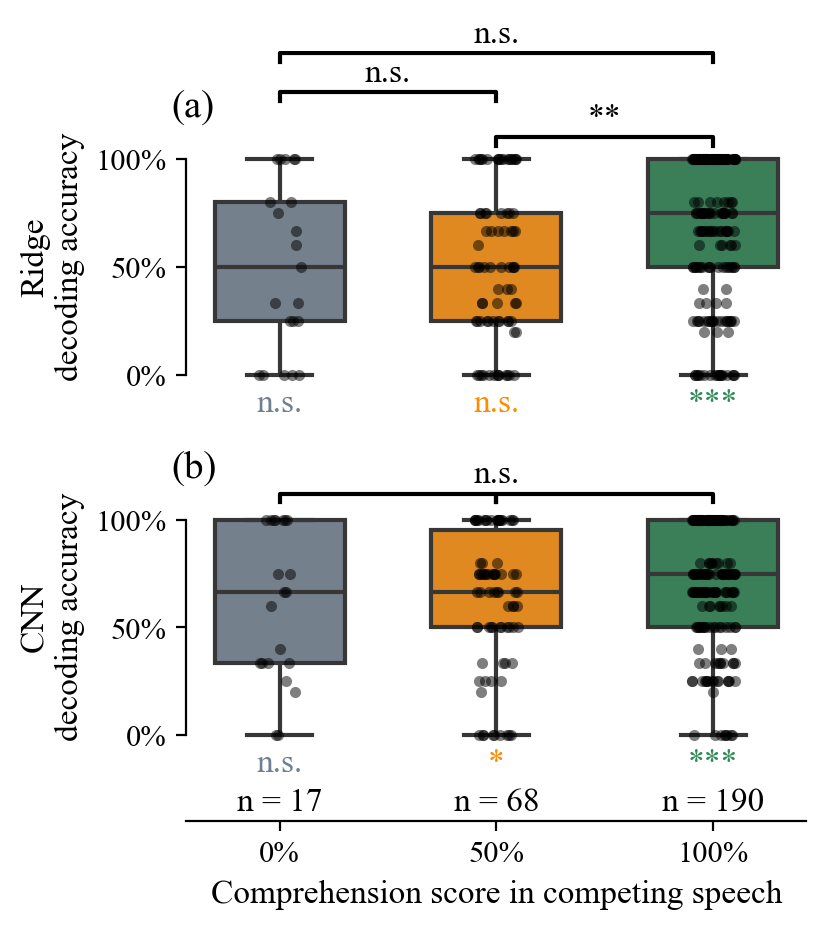

In [313]:
#figure with two subplots
fig, (ax, ax1) = plt.subplots(2, 1, figsize=(4, 5.0), dpi=200)
plt.subplots_adjust(hspace=-0.12)
plot_ridge(ax)
plot_cnn(ax1)
ax.text(-0.5, 1.2, '(a)', fontsize=14)
ax.spines['bottom'].set_visible(False)
ax.set_xticks([])
ax.set_zorder(0)

ax1.text(-0.5, 1.2, '(b)', fontsize=14)
fig_path = os.path.join(base_dir, 'reports', 'figures', 'decoding')
fig_name = 'decoding_accuracy_comprehension_score_ci_overview'
#save as pdf
fig.savefig(os.path.join(fig_path, fig_name + '.pdf'), bbox_inches='tight', dpi = 1000)

# Linear Mixed Model


In [314]:
#reorder categories to have 100 as reference
df_acc["comprehension"] = df_acc["comprehension"].astype('category')
df_acc["comprehension"].cat.reorder_categories(['100', '50', '0'], inplace=True)

df_acc_cnn["comprehension"] = df_acc_cnn["comprehension"].astype('category')
df_acc_cnn["comprehension"].cat.reorder_categories(['100', '50', '0'], inplace=True)

WARNING    /var/folders/ll/btjq1lpn2msbmbn34rst5wz80000gp/T/ipykernel_76848/4152014132.py:3: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  df_acc["comprehension"].cat.reorder_categories(['100', '50', '0'], inplace=True)
 [py.warnings]
WARNING    /var/folders/ll/btjq1lpn2msbmbn34rst5wz80000gp/T/ipykernel_76848/4152014132.py:6: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  df_acc_cnn["comprehension"].cat.reorder_categories(['100', '50', '0'], inplace=True)
 [py.warnings]


In [315]:
#combin df_acc and df_acc_cnn
df_acc['model'] = 'Ridge'
df_acc_cnn['model'] = 'CNN'

df_acc_comb = pandas.concat([df_acc, df_acc_cnn])

In [316]:
data = pg.read_dataset('icc')

In [317]:
df_acc_comb

,decoding,comprehension,subject,trials,model
0,0.000000,0,102,9,Ridge
1,0.666667,0,102,10,Ridge
2,0.000000,0,102,11,Ridge
3,0.333333,0,102,12,Ridge
4,1.000000,0,102,13,Ridge
...,...,...,...,...,...
295,0.400000,100,130,16,CNN
296,0.750000,100,130,17,CNN
297,1.000000,100,130,18,CNN
298,1.000000,100,130,19,CNN


### Intraclass correlation

In [320]:
pg.intraclass_corr(data=df_acc, targets='trials', raters='subject', ratings='decoding')

,Type,Description,ICC,F,df1,df2,pval,CI95%
0,ICC1,Single raters absolute,0.011553,1.292191,11,288,0.228076,"[-0.01, 0.1]"
1,ICC2,Single random raters,0.013081,1.344860,11,264,0.199721,"[-0.01, 0.1]"
2,ICC3,Single fixed raters,0.013607,1.344860,11,264,0.199721,"[-0.01, 0.1]"
3,ICC1k,Average raters absolute,0.226120,1.292191,11,288,0.228076,"[-0.58, 0.73]"
4,ICC2k,Average random raters,0.248885,1.344860,11,264,0.199721,"[-0.49, 0.74]"
5,ICC3k,Average fixed raters,0.256428,1.344860,11,264,0.199721,"[-0.52, 0.74]"


In [321]:
pg.intraclass_corr(data=df_acc_cnn, targets='trials', raters='subject', ratings='decoding')

,Type,Description,ICC,F,df1,df2,pval,CI95%
0,ICC1,Single raters absolute,-0.008422,0.791212,11,288,0.648866,"[-0.03, 0.05]"
1,ICC2,Single random raters,-0.007186,0.816044,11,264,0.624044,"[-0.02, 0.05]"
2,ICC3,Single fixed raters,-0.007413,0.816044,11,264,0.624044,"[-0.02, 0.05]"
3,ICC1k,Average raters absolute,-0.263884,0.791212,11,288,0.648866,"[-1.58, 0.57]"
4,ICC2k,Average random raters,-0.217075,0.816044,11,264,0.624044,"[-1.4, 0.57]"
5,ICC3k,Average fixed raters,-0.225424,0.816044,11,264,0.624044,"[-1.5, 0.58]"


## Ridge model only

In [223]:
ridge_mixed_model = smf.mixedlm('decoding ~ comprehension', df_acc, groups=df_acc['subject'])
ridge_mixed_model_fit = ridge_mixed_model.fit(method='powell')
ridge_residuals = ridge_mixed_model_fit.resid
print('Ridge Model')
ridge_mixed_model_fit.summary()

WARNING    /Users/constantin/opt/anaconda3/envs/ci_hi_nh_study/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
 [py.warnings]


Ridge Model


<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
==============================================================
Model:               MixedLM   Dependent Variable:   decoding 
No. Observations:    300       Method:               REML     
No. Groups:          25        Scale:                0.1179   
Min. group size:     12        Log-Likelihood:       -110.2812
Max. group size:     12        Converged:            Yes      
Mean group size:     12.0                                     
--------------------------------------------------------------
                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept            0.680    0.024 28.069 0.000  0.632  0.727
comprehension[T.50] -0.163    0.046 -3.567 0.000 -0.253 -0.074
comprehension[T.0]  -0.178    0.079 -2.263 0.024 -0.333 -0.024
Group Var            0.000    0.009                           
==============================================================

"""

### Q-Q plot of residuals

              W      pval  equal_var
levene  1.31965  0.268791       True
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Text(0.5, 1.0, 'Ridge residuals')

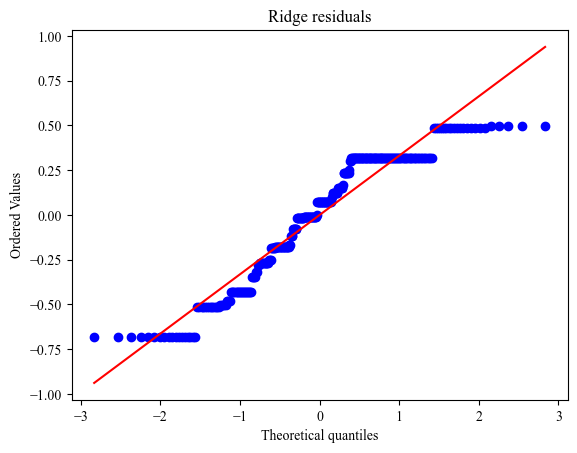

In [224]:
pg.homoscedasticity(df_acc, dv='decoding', group='comprehension')
print(pg.homoscedasticity(df_acc, dv='decoding', group='comprehension'))
scipy.stats.probplot(ridge_residuals, plot=plt)
plt.title('Ridge residuals')

### Residual vs. fitted plot

Text(0.5, 1.0, 'Ridge residuals vs. fitted values')

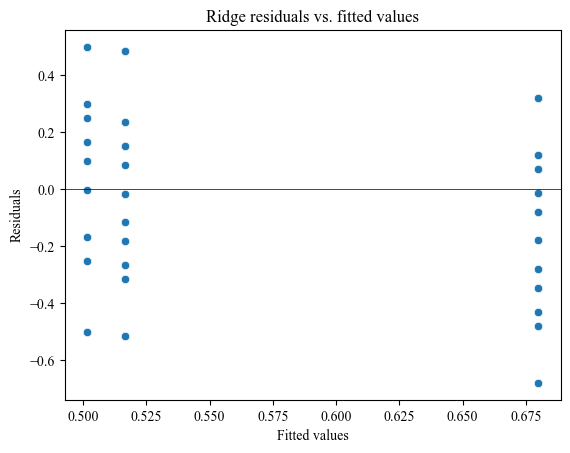

In [225]:
ridge_fitted_values = ridge_mixed_model_fit.fittedvalues
fig, ax = plt.subplots()
sns.scatterplot(x=ridge_fitted_values, y=ridge_residuals, ax=ax)
plt.axhline(0, color='black', linewidth=0.5)
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Ridge residuals vs. fitted values')

# CNN Model

In [226]:
cnn_mixed_model = smf.mixedlm('decoding ~ comprehension', df_acc_cnn, groups=df_acc_cnn['subject'])
cnn_mixed_model_fit = cnn_mixed_model.fit(method='powell')
print('CNN Model')
cnn_mixed_model_fit.summary()

WARNING    /Users/constantin/opt/anaconda3/envs/ci_hi_nh_study/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
 [py.warnings]


CNN Model


<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
==============================================================
Model:                MixedLM   Dependent Variable:   decoding
No. Observations:     300       Method:               REML    
No. Groups:           25        Scale:                0.0871  
Min. group size:      12        Log-Likelihood:       -67.8048
Max. group size:      12        Converged:            Yes     
Mean group size:      12.0                                    
--------------------------------------------------------------
                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept            0.700    0.023 30.038 0.000  0.654  0.746
comprehension[T.50] -0.075    0.044 -1.718 0.086 -0.161  0.011
comprehension[T.0]  -0.099    0.075 -1.323 0.186 -0.246  0.048
Group Var            0.002    0.010                           
==============================================================

"""

### Q-Q plot residuals

               W      pval  equal_var
levene  2.255336  0.106631       True
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Text(0.5, 1.0, 'CNN residuals')

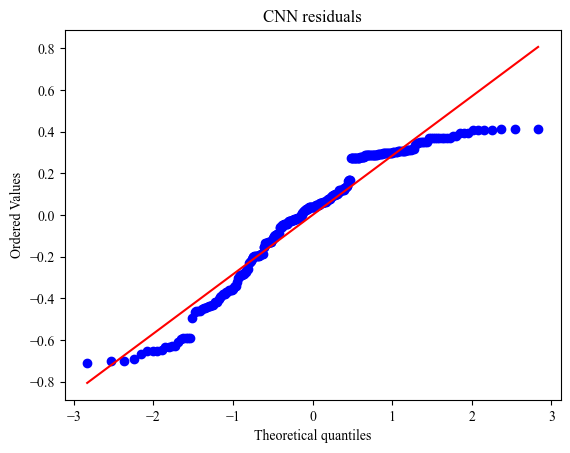

In [227]:
print(pg.homoscedasticity(df_acc_cnn, dv='decoding', group='comprehension'))
cnn_residuals = cnn_mixed_model_fit.resid
scipy.stats.probplot(cnn_residuals, plot=plt)
plt.title('CNN residuals')

### Residuals vs. fitted plot

Text(0.5, 1.0, 'CNN residuals vs. fitted')

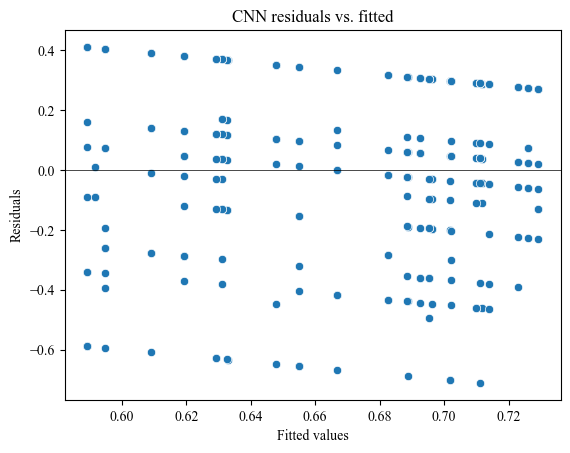

In [228]:
cnn_fitted_values = cnn_mixed_model_fit.fittedvalues
fig, ax = plt.subplots()
sns.scatterplot(x=cnn_fitted_values, y=cnn_residuals, ax=ax)
plt.axhline(0, color='black', linewidth=0.5)
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('CNN residuals vs. fitted')


# One model over Ridge and CNN

In [229]:
#mixed model
mixed_model = smf.mixedlm('decoding ~ comprehension * model', df_acc_comb, groups=df_acc_comb['subject'])
mixed_model_fit = mixed_model.fit()

additive_mixed_model = smf.mixedlm('decoding ~ comprehension + model', df_acc_comb, groups=df_acc_comb['subject'])
additive_mixed_model_fit = additive_mixed_model.fit()

print('Mixed Model')
print(mixed_model_fit.summary())

print('Additive Model')
print(additive_mixed_model_fit.summary())

WARNING    /Users/constantin/opt/anaconda3/envs/ci_hi_nh_study/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
 [py.warnings]
WARNING    /Users/constantin/opt/anaconda3/envs/ci_hi_nh_study/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
 [py.warnings]


Mixed Model
                    Mixed Linear Model Regression Results
Model:                    MixedLM        Dependent Variable:        decoding 
No. Observations:         600            Method:                    REML     
No. Groups:               25             Scale:                     0.1000   
Min. group size:          24             Log-Likelihood:            -178.7000
Max. group size:          24             Converged:                 Yes      
Mean group size:          24.0                                               
-----------------------------------------------------------------------------
                                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------
Intercept                           0.700    0.027 26.219 0.000  0.648  0.753
comprehension[T.50]                -0.076    0.050 -1.519 0.129 -0.173  0.022
comprehension[T.0]                 -0.102    0.085 -1.197 0.231 -0.268  

In [230]:
additive_mixed_model_fit.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
==============================================================
Model:               MixedLM   Dependent Variable:   decoding 
No. Observations:    600       Method:               REML     
No. Groups:          25        Scale:                0.1001   
Min. group size:     24        Log-Likelihood:       -176.6405
Max. group size:     24        Converged:            Yes      
Mean group size:     24.0                                     
--------------------------------------------------------------
                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept            0.714    0.025 28.430 0.000  0.665  0.764
comprehension[T.50] -0.119    0.040 -2.988 0.003 -0.198 -0.041
comprehension[T.0]  -0.141    0.068 -2.085 0.037 -0.274 -0.008
model[T.Ridge]      -0.048    0.026 -1.878 0.060 -0.099  0.002
Group Var            0.004    0.008                           
==============================================================

"""

### Q-Q plot

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Text(0.5, 1.0, 'Ridge and CNN model residuals')

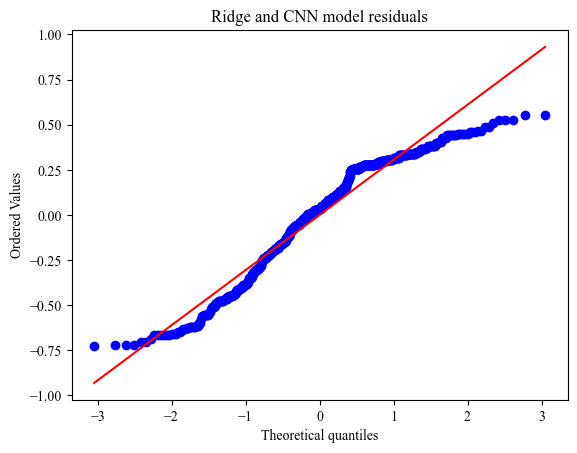

In [231]:
mixed_model_residuals = mixed_model_fit.resid
scipy.stats.probplot(mixed_model_residuals, plot=plt)
plt.title('Ridge and CNN model residuals')

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Text(0.5, 1.0, 'Additive model residuals')

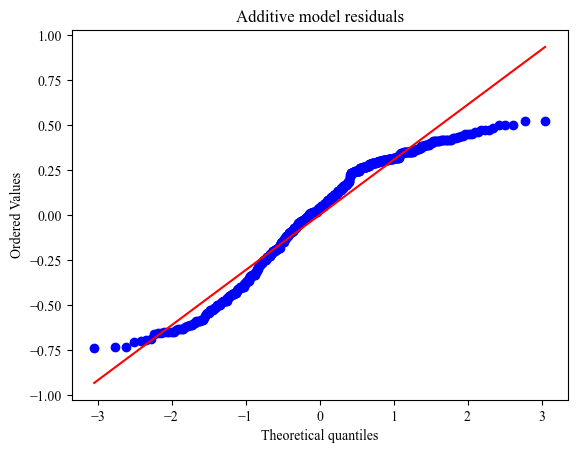

In [232]:
additive_mixed_model_residuals = additive_mixed_model_fit.resid
scipy.stats.probplot(additive_mixed_model_residuals, plot=plt)
plt.title('Additive model residuals')

### Resiudals vs. fitted

Text(0.5, 1.0, 'Ridge and CNN residuals vs. fitted')

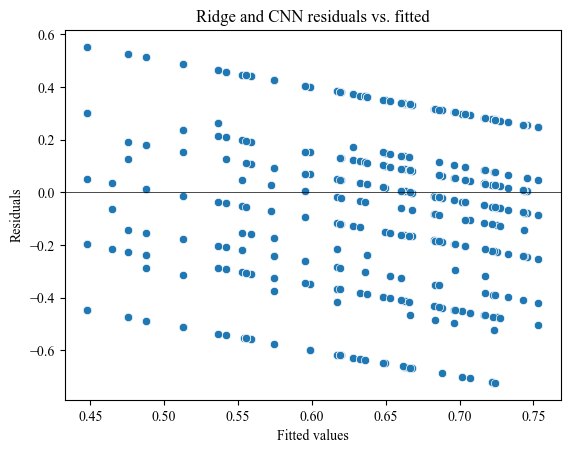

In [233]:
ridge_and_cnn_fitted_values = mixed_model_fit.fittedvalues
fig, ax = plt.subplots()
sns.scatterplot(x=ridge_and_cnn_fitted_values, y=mixed_model_residuals, ax=ax)
plt.axhline(0, color='black', linewidth=0.5)
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Ridge and CNN residuals vs. fitted')

Text(0.5, 1.0, 'Ridge and CNN (additive) residuals vs. fitted')

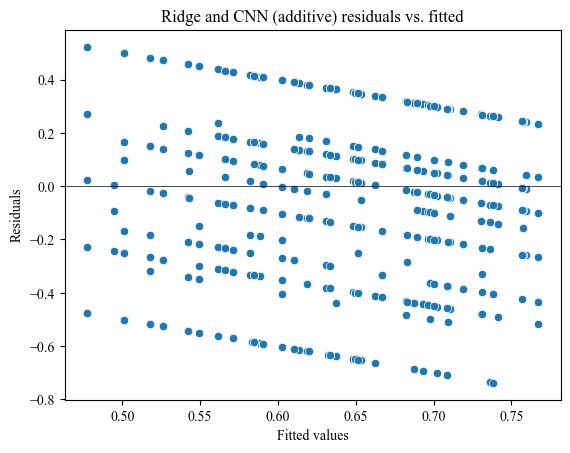

In [234]:
ridge_and_cnn_additive_fitted_values = additive_mixed_model_fit.fittedvalues
fig, ax = plt.subplots()
sns.scatterplot(x=ridge_and_cnn_additive_fitted_values, y=additive_mixed_model_residuals, ax=ax)
plt.axhline(0, color='black', linewidth=0.5)
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Ridge and CNN (additive) residuals vs. fitted')

In [235]:
# durbon-watson
import statsmodels.api as sm

dw_stat_mixed = sm.stats.durbin_watson(mixed_model_residuals)
dw_stat_ridge = sm.stats.durbin_watson(ridge_residuals)
dw_stat_cnn = sm.stats.durbin_watson(cnn_residuals)

In [236]:
print(f'Durbin-Watson statistic for mixed model: {dw_stat_mixed}')
print(f'Durbin-Watson statistic for ridge model: {dw_stat_ridge}')
print(f'Durbin-Watson statistic for cnn model: {dw_stat_cnn}')

Durbin-Watson statistic for mixed model: 2.2180037903352425
Durbin-Watson statistic for ridge model: 2.141395686132144
Durbin-Watson statistic for cnn model: 2.153430724884968


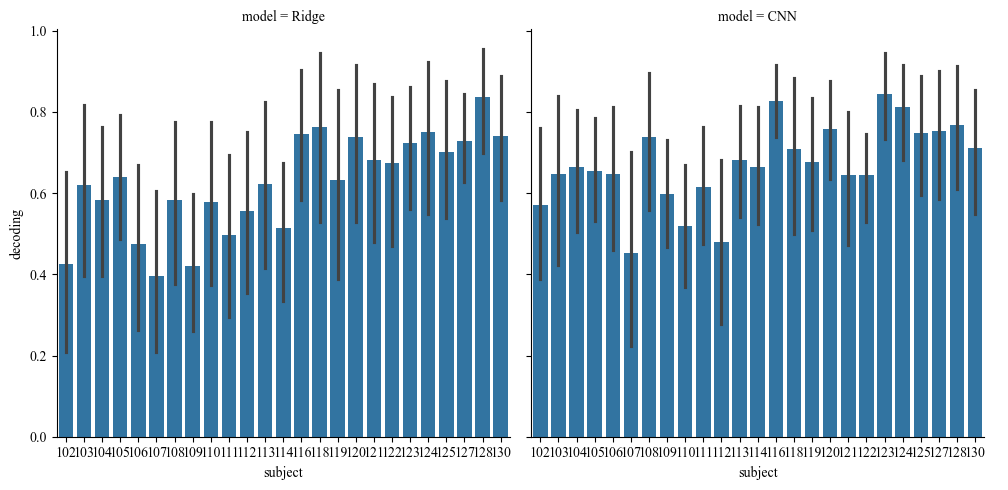

In [237]:
sns.catplot(data=df_acc_comb, x='subject', y='decoding', kind='bar', col='model')

df_acc

In [238]:
pg.anova(df_acc, dv='decoding', between='subject', detailed=True)
#correct for multiple comparisons

,Source,SS,DF,MS,F,p-unc,np2
0,subject,4.187820,24,0.174493,1.468857,0.076612,0.113625
1,Within,32.668565,275,0.118795,NaN,NaN,NaN


In [239]:
def intr_vs_inter_group_var(df):
    intra_subject_variance = df.groupby('subject')['decoding'].var().mean()
    print(f"Intra-subject variance: {intra_subject_variance}")

    # Step 2: Calculate the inter-subject variance
    # First, calculate the mean decoding for each subject
    subject_means = df.groupby('subject')['decoding'].mean()

    # Then calculate the variance of these means (inter-subject variance)
    inter_subject_variance = subject_means.var()
    print(f"Inter-subject variance: {inter_subject_variance}")

    # Step 3: Calculate the ratio of intra-subject to inter-subject variance
    variance_ratio = intra_subject_variance / inter_subject_variance
    print(f"Ratio of intra-subject to inter-subject variance: {variance_ratio}")

In [240]:
intr_vs_inter_group_var(df_acc)

Intra-subject variance: 0.11879478114478115
Inter-subject variance: 0.014541042952674896
Ratio of intra-subject to inter-subject variance: 8.169619024674448


In [241]:
intr_vs_inter_group_var(df_acc_cnn)

Intra-subject variance: 0.08693122895622896
Inter-subject variance: 0.010046566358024695
Ratio of intra-subject to inter-subject variance: 8.652829818497406


In [333]:
# Model with subject as a random effect
model_with_subject = smf.mixedlm("decoding ~ comprehension + model", df_acc, groups=df_acc["subject"]).fit()

# Model without subject as a random effect (OLS regression)
model_without_subject = smf.ols("decoding ~ comprehension + model", data=df_acc).fit()

# Likelihood Ratio Test
import scipy.stats as stats

lr_stat = 2 * (model_with_subject.llf - model_without_subject.llf)
p_value = stats.chi2.sf(lr_stat, df=1)

print(f"Likelihood Ratio Test p-value: {p_value}")

WARNING    /Users/constantin/opt/anaconda3/envs/ci_hi_nh_study/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 [py.warnings]
WARNING    /Users/constantin/opt/anaconda3/envs/ci_hi_nh_study/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
 [py.warnings]
WARNING    /Users/constantin/opt/anaconda3/envs/ci_hi_nh_study/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
 [py.warnings]


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Likelihood Ratio Test p-value: 1.0


In [334]:
(model_with_subject.llf - model_without_subject.llf)

-6.825497073535132

In [335]:
model_with_subject.llf

-110.29667146658278

In [336]:
model_without_subject.llf

-103.47117439304765

In [328]:
model_with_subject.llf - model_without_subject.llf

-6.825497073535132